Source:https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV
from time import time
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector

Loading the given diabetes dataset +Standardizing the features.

In [3]:
import pandas as pd
from sklearn.datasets import load_diabetes

# Load the scikit-learn diabetes dataset
sklearn_diabetes = load_diabetes()
sklearn_format = pd.DataFrame(sklearn_diabetes.data, columns=sklearn_diabetes.feature_names)

# Load your CSV
data = pd.read_csv('diabetes.csv')

# Standardize features like scikit-learn dataset
def standardize(x):
   return (x - x.mean()) / x.std()

# Create matching features
processed_data = pd.DataFrame({
   'age': standardize(data['Age']),
   'sex': standardize(data['Pregnancies']),  # Using pregnancies as proxy for sex
   'bmi': standardize(data['BMI']),
   'bp': standardize(data['BloodPressure']),
   's1': standardize(data['SkinThickness']), 
   's2': standardize(data['Glucose']),
   's3': standardize(data['DiabetesPedigreeFunction']),
   's4': standardize(data['Insulin']),
   's5': standardize(data['BMI'] * data['Age'] / 100),  # Creating derived feature
   's6': standardize(data['DiabetesPedigreeFunction'] * data['Age'] / 100)  # Creating derived feature
})

# Add target variable
processed_data['target'] = data['Outcome']

In [4]:
x,y=processed_data[[col for col in processed_data.columns if col != 'target']],processed_data.target

Feature importance from coefficients:Using the RidgeCV estimator. The features with the highest absolute coef_ value are considered the most important.

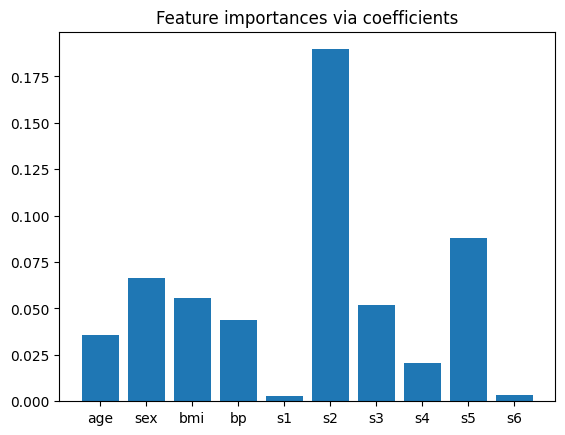

In [5]:


ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(x, y)
importance = np.abs(ridge.coef_)
feature_names = np.array(x.columns)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

To select the two features which are the most important according to the coefficients, the SelectFrom Model accepts a threshold parameter and will select the features whose importance (defined by the coefficients) are above this threshold.

In [6]:
threshold = np.sort(importance)[-3] + 0.01
tic = time()
sfm = SelectFromModel(ridge, threshold=threshold).fit(x, y)
toc = time()
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['s2' 's5']
Done in 0.001s


Selecting features with Sequential Feature Selection which is a greedy procedure where, at each iteration, we choose the best new feature to add to our selected features based a cross-validation score. That is, we start with 0 features and choose the best single feature with the highest score. The procedure is repeated until we reach the desired number of selected features.

In [7]:
tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=2, direction="forward"
).fit(x, y)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=2, direction="backward"
).fit(x, y)
toc_bwd = time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by forward sequential selection: ['s2' 's5']
Done in 0.102s
Features selected by backward sequential selection: ['bmi' 's2']
Done in 0.285s


SequentialFeatureSelector can be used to remove features present in the dataset and return a smaller subset of the original features with direction="backward" and a negative value of tol.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

for tol in [-1e-2, -1e-3, -1e-4]:
    start = time()
    feature_selector = SequentialFeatureSelector(
        LogisticRegression(),
        n_features_to_select="auto",
        direction="backward",
        scoring="roc_auc",
        tol=tol,
        n_jobs=2,
    )
    model = make_pipeline(StandardScaler(), feature_selector, LogisticRegression())
    model.fit(x, y)
    end = time()
    print(f"\ntol: {tol}")
    print(f"Features selected: {feature_names[model[1].get_support()]}")
    print(f"ROC AUC score: {roc_auc_score(y, model.predict_proba(x)[:, 1]):.3f}")
    print(f"Done in {end - start:.3f}s")


tol: -0.01
Features selected: ['sex' 'bmi' 's2']
ROC AUC score: 0.826
Done in 1.495s

tol: -0.001
Features selected: ['sex' 'bmi' 'bp' 's2' 's3']
ROC AUC score: 0.837
Done in 0.530s

tol: -0.0001
Features selected: ['sex' 'bmi' 'bp' 's1' 's2' 's3' 's5']
ROC AUC score: 0.839
Done in 0.401s


Univariate Feature Selection.
Significant features have the highest scores

In [9]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=4)
selector.fit(x, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

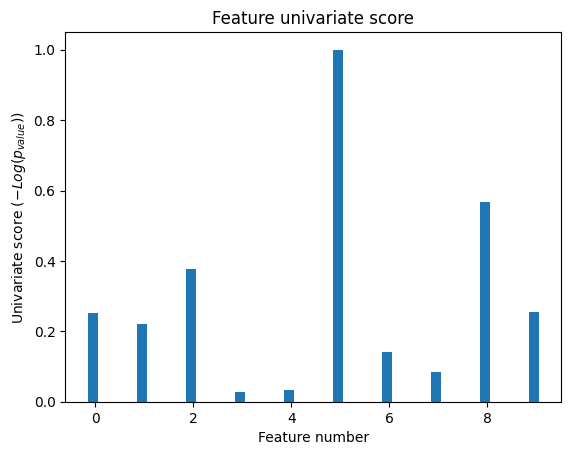

In [10]:
X_indices = np.arange(x.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

removing features with low variance

In [11]:
from sklearn.feature_selection import VarianceThreshold
X = processed_data
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[ 1.42506672,  0.63953049,  0.20387991, ...,  1.35547016,
         1.20167746,  1.        ],
       [-0.19054773, -0.84433482, -0.68397621, ..., -0.53543397,
        -0.3817803 ,  0.        ],
       [-0.10551539,  1.23307662, -1.10253696, ..., -0.71006739,
         0.44000248,  1.        ],
       ...,
       [-0.27558007,  0.34275743, -0.73471085, ..., -0.62076118,
        -0.6549343 ,  0.        ],
       [ 1.1699697 , -0.84433482, -0.24004815, ...,  0.76901135,
         0.04539512,  1.        ],
       [-0.87080644, -0.84433482, -0.20199718, ..., -0.81263689,
        -0.66305698,  0.        ]])